In [1]:
#dependencies: matplotlib, numpy, pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#sql alchemy dependencies, and datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [7]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd196df1dc0>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [8]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd196e05640>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168}

In [9]:
#most recent date - using an order by for date, descending order, getting the first result back
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [10]:
#separating the date segments out to use in the year before query
ld_year = int(latest_date[0][0:4])
ld_month = int(latest_date[0][5:7])
ld_day = int(latest_date[0][-2:])
ld_year, ld_month, ld_day

(2017, 8, 23)

In [11]:
#finding a year before the most recent date
year_before = (dt.date(ld_year, ld_month, ld_day) - dt.timedelta(days=365)).strftime('%Y-%m-%d')
year_before

'2016-08-23'

In [12]:
# getting precipitation data for last 12 months in dataset
dates_list = []
precips_list = []
pdata = session.query(Measurement).filter(Measurement.date >= year_before).all()
for row in pdata:
    dates_list.append(row.date)
    precips_list.append(row.prcp)

In [13]:
#replacing NaNs with zeros
precips_list_fix = [0 if x == None else x for x in precips_list]

In [14]:
#creating df out of dates and precipitation lists
#setting index as date
#sorting index (dates)
prcp_data = pd.DataFrame(
    {'date': dates_list, 'precipitation': precips_list_fix}
    ).set_index('date').sort_index()
prcp_data.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [15]:
#creating a list of all the unique dates in the df to see if the x axis in the graph can be labelled for every nth value
each_date = [x for x in prcp_data.index.unique()]

In [16]:
#for loop to see how many rows there are per date - they vary, so it can't be used to mark the x axis for every nth value
num_measurements = []
for item in each_date:
    length = len(prcp_data[prcp_data.index == item])
    num_measurements.append(length)
unique_no_measurements = set(num_measurements)
unique_no_measurements

{3, 4, 5, 6, 7}

In [17]:
#prep for graph: xticks and labels for only every 250 data points
#lists to hold the xticks and the labels
num_of_x = list(np.arange(1, (len(prcp_data['precipitation'])+1), 250))
x_names = [x for x in prcp_data.index]
x_labels = [x_names[x] for x in num_of_x]

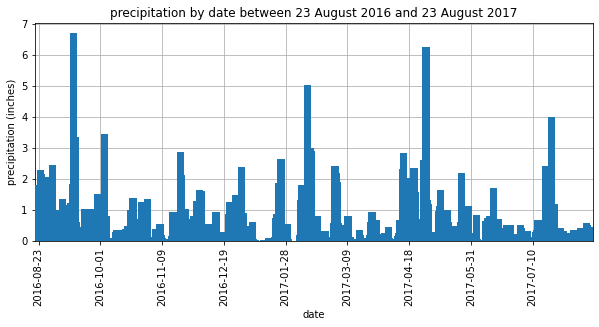

In [18]:
#graph of precipitation data
ax = prcp_data.plot(
    kind='bar', legend=False, rot=90, width=30, figsize=(10,4), zorder=3
    )
ax.set_xticks(num_of_x, minor=False)
ax.set_xticklabels(x_labels)
ax.grid(True, which='major', zorder=0)
plt.ylabel('precipitation (inches)')
plt.title('precipitation by date between 23 August 2016 and 23 August 2017')

plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [20]:
# total number stations in the dataset
#checking both tables to see if same answer is given
print(f'Number of stations according to Station table: {session.query(Station.id).group_by(Station.id).count()}') 
print(f'Number of stations according to Measurement table: {session.query(Measurement.station).group_by(Measurement.station).count()}')
print(f'Number of stations by inner join of both tables: {session.query(Measurement.station, Station.id).filter(Measurement.station == Station.station).group_by(Station.id).count()}')

Number of stations according to Station table: 9
Number of stations according to Measurement table: 9
Number of stations by inner join of both tables: 9


In [21]:
# finding the most active station
# stations and row counts in descending order
station_count = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc())
for row in station_count:
    print(row)
most_active_station_id = station_count[0][0]
f'The most active station ID is {most_active_station_id}'

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


'The most active station ID is USC00519281'

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).scalar()

print(f'min temp for station {most_active_station_id}: {min_temp}')
print(f'max temp for station {most_active_station_id}: {max_temp}')
print(f'average temp for station {most_active_station_id}: {avg_temp}')

min temp for station USC00519281: 54.0
max temp for station USC00519281: 85.0
average temp for station USC00519281: 71.66378066378067


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps_df = pd.DataFrame(session.query(Measurement.tobs, Measurement.id).filter(Measurement.date >= year_before).filter(Measurement.station==most_active_station_id))
temps_df.set_index('id', inplace=True)
temps_df.head()

,tobs
id,
14608,77.0
14609,77.0
14610,80.0
14611,80.0
14612,75.0


array([[<AxesSubplot:title={'center':'tobs'}>]], dtype=object)

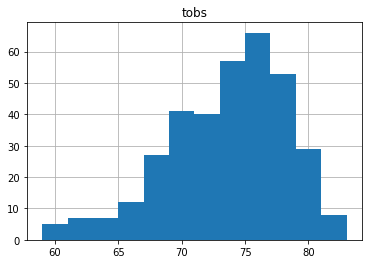

In [24]:
temps_df.hist(bins=12, zorder=3)

# Close session

In [25]:
# Close Session
#session.close()